## Plant Pathology
[Kaggle link](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data)

Based on- https://github.com/bam098/plant_pathology/blob/main/bam098_plant_pathology_v8_cln.ipynb

### Install, Imports, Download, and Random Seed

In [96]:
! pip uninstall fastai -y
! pip install fastai

Uninstalling fastai-2.1.8:
  Successfully uninstalled fastai-2.1.8
  Using cached https://files.pythonhosted.org/packages/ff/53/da994550c0dd2962351fd694694e553afe0c9516c02251586790f830430b/fastai-2.1.8-py3-none-any.whl


In [97]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [98]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
import torch
import torchvision
import pandas as pd

In [99]:
print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.5
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla P4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [100]:
random_seed = 42

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/gdrive/MyDrive/Kaggle/plant_pathology')
img_dir = data_dir / 'images'

img_size = 300
bs = 25
arch = resnet50
lr = 1e-2

In [101]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Data

In [102]:
data_dir.ls()

(#5) [Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/sample_submission.csv'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/test.csv'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/train.csv'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/.ipynb_checkpoints')]

In [103]:
img_dir.ls()

(#3642) [Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_0.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_10.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_100.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1000.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1001.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1002.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1003.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1004.jpg'),Path('/content/gdrive/MyDrive/Kaggle/plant_pathology/images/Test_1005.jpg')...]

### EDA

In [104]:
train_df = pd.read_csv(data_dir/'train.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [105]:
train_df.shape

(1821, 5)

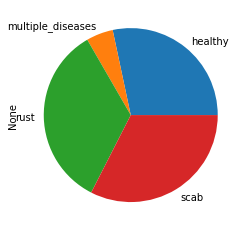

In [106]:
train_df[labels].sum().plot(kind='pie')

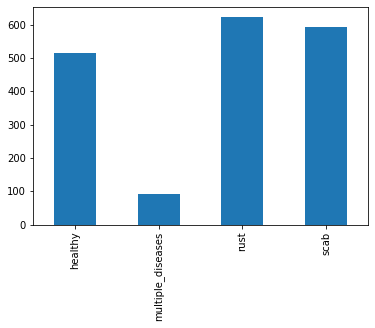

In [107]:
train_df[labels].sum().plot(kind='bar')

### Data Loading

In [108]:
train_df['label'] = train_df[labels].idxmax(axis=1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [109]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [110]:
# oversampling, ref: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

train_df_bal = pd.concat(
    [train_df.query('label != "multiple_diseases"'), train_df] +
    [train_df.query('label == "multiple_diseases"')] * 2
).sample(frac=1.0, random_state=random_seed).reset_index(drop=True)

In [111]:
train_df_bal['label'].value_counts()

rust                 1244
scab                 1184
healthy              1032
multiple_diseases     273
Name: label, dtype: int64

In [112]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()),
    getters=[ColReader('image_id',
                       pref=img_dir,
                       suff='.jpg'), ColReader('label')],
    splitter=RandomSplitter(valid_pct=0.1, seed=random_seed),
    item_tfms=Resize(img_size),
    batch_tfms=aug_transforms(size=img_size,
                              max_rotate=30.,
                              min_scale=0.75,
                              flip_vert=True,
                              do_flip=True)
)

In [113]:
dls = db.dataloaders(train_df_bal, bs=bs)

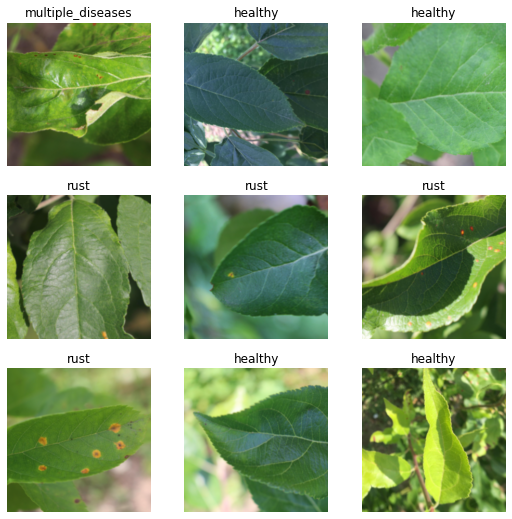

In [114]:
dls.show_batch()

### Metric

In [115]:
def comp_metric(preds, targs, labels=range(len(labels))):
  targs = np.eye(4)[targs]
  return np.mean([roc_auc_score(targs[:,i], preds[:, i]) for i in labels])

def healthy_roc_auc(*args):
  return comp_metric(*args, lables=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

### Training

In [116]:
learn = cnn_learner(
    dls,
    resnet50,
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]
).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=5.248074739938602e-05)

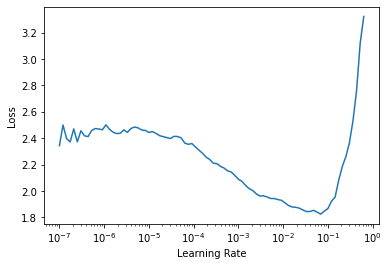

In [117]:
learn.lr_find()

In [118]:
learn.fit_one_cycle(5, 10e-2)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.995829,2.004603,0.715818,0.832817,03:17
1,0.932563,0.772862,0.828418,0.936270,03:16
2,0.741629,0.625369,0.922252,0.912229,03:16
3,0.649327,0.477303,0.946381,0.962540,03:16
4,0.548537,0.465746,0.943700,0.988470,03:16


In [119]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [122]:
learn_stage_1 = learn.load('/content/gdrive/MyDrive/Kaggle/plant_pathology/stage-1')

In [123]:
learn.fit_one_cycle(10, 10e-2)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.613353,1.088014,0.541555,0.887887,03:13
1,2.213557,9.696366,0.568365,0.732196,03:13
2,1.142205,0.685752,0.863271,0.914281,03:13
3,1.028124,1.975182,0.882038,0.924038,03:14
4,1.096273,1.537729,0.844504,0.940530,03:15
5,0.770713,0.554932,0.919571,0.973754,03:14
6,0.678644,1.024027,0.865952,0.923763,03:15
7,0.602672,0.613580,0.892761,0.960473,03:14
8,0.561177,0.463892,0.951743,0.986001,03:15
9,0.541444,1.000319,0.943700,0.986004,03:13


In [124]:
learn.save('stage-2')

Path('models/stage-2.pth')

### Interpretation and Test

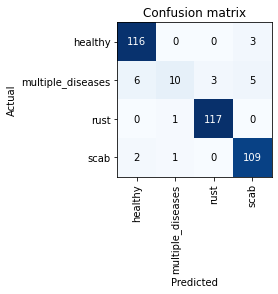

In [126]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

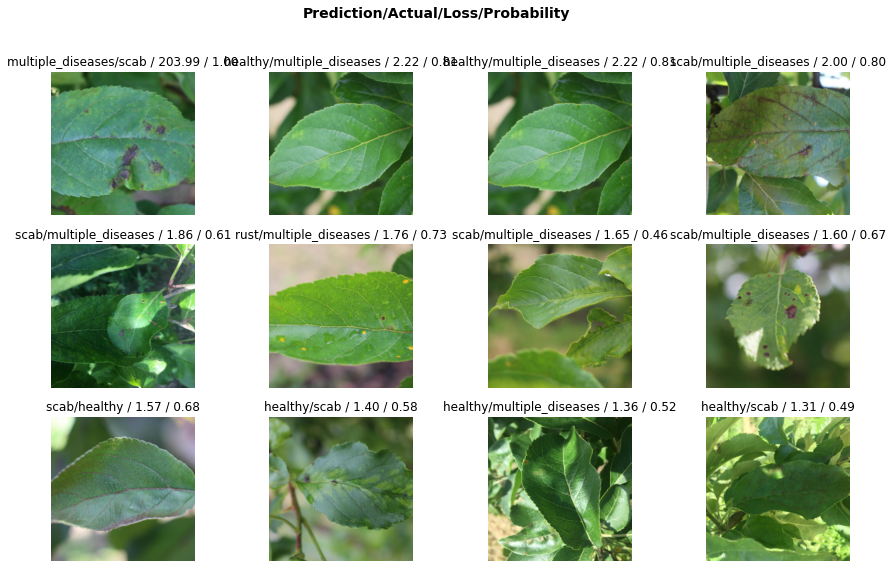

In [127]:
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [129]:
test_df = pd.read_csv(data_dir/'test.csv')
test_dl = dls.test_dl(test_df)

In [130]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [131]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1)
sub_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.038409,0.104254,0.814426,0.042911
1,Test_1,0.049178,0.072336,0.852760,0.025726
2,Test_2,0.022157,0.017691,0.016635,0.943517
3,Test_3,0.965258,0.010967,0.016399,0.007377
4,Test_4,0.038400,0.045959,0.889043,0.026599
...,...,...,...,...,...
1816,Test_1816,0.026015,0.069240,0.875935,0.028811
1817,Test_1817,0.016412,0.057636,0.019301,0.906651
1818,Test_1818,0.041327,0.045800,0.882311,0.030562
1819,Test_1819,0.921324,0.035741,0.024866,0.018069


### Submission

In [132]:
! pip uninstall -y kaggle
! pip install kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=c22d3a0824fbd391e742c27fb2e447e44a9d6d54d084cc3e83507f468cf85e1d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [133]:
! cp /content/gdrive/MyDrive/Kaggle/kaggle.json /root/

In [134]:
!kaggle --version

Kaggle API 1.5.10


In [135]:
sub_df.to_csv('submission.csv', index=False)

In [136]:
! head -n 5 submission.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.03840871,0.10425447,0.814426,0.04291083
Test_1,0.04917823,0.07233552,0.8527602,0.02572599
Test_2,0.022156907,0.017690923,0.016635321,0.9435168
Test_3,0.9652577,0.0109666195,0.016398663,0.007377034
